In [229]:
import sqlite3 
import pandas as pd 
import time
from datetime import datetime
import matplotlib.pyplot as plt


connection = sqlite3.connect("collection.anki2")
cursor = connection.cursor()
df = cursor.execute("SELECT * FROM revlog").fetchall()
df = pd.DataFrame(df)
connection.close()

df.rename(columns={0: "id", 1: "cid", 2: "usn", 3: "ease", 
    4:"ivl", 5:"lastIvl", 6:"factor", 7:"time", 8: "type"},inplace=True)

df['timestamp'] = 0
df['date'] = 0

## Anki's table schema

- Schema available at https://github.com/ankidroid/Anki-Android/wiki/Database-Structure

In [133]:
"""
CREATE TABLE revlog (
    id              integer primary key,
       -- epoch-milliseconds timestamp of when you did the review
    cid             integer not null,
       -- cards.id
    usn             integer not null,
        -- update sequence number: for finding diffs when syncing. 
        --   See the description in the cards table for more info
    ease            integer not null,
       -- which button you pushed to score your recall. 
       -- review:  1(wrong), 2(hard), 3(ok), 4(easy)
       -- learn/relearn:   1(wrong), 2(ok), 3(easy)
    ivl             integer not null,
       -- interval (i.e. as in the card table)
    lastIvl         integer not null,
       -- last interval (i.e. the last value of ivl. Note that this 
       -- value is not necessarily equal to the actual interval 
       -- between this review and the preceding review)
    factor          integer not null,
      -- factor
    time            integer not null,
       -- how many milliseconds your review took, up to 60000 (60s)
    type            integer not null
       --  0=learn, 1=review, 2=relearn, 3=cram
)""";

In [232]:
# Converting from unix epoch time 

for i in range(df.shape[0]): 
    df.iloc[i,9] = pd.to_datetime(df.iloc[i,0], unit='ms').time()
    df.iloc[i,10] = pd.to_datetime(df.iloc[i,0], unit='ms').date()

# Getting the day

In [237]:
day_avgs = df.groupby('date').mean()
day_avgs.head()

,id,cid,usn,ease,ivl,lastIvl,factor,time,type
date,,,,,,,,,
2021-09-28,1.632821e+12,1.632679e+12,2.055556,2.666667,-309.500000,-240.000000,833.333333,8834.611111,0.000000
2021-09-29,1.632913e+12,1.632840e+12,5.000000,3.000000,-268.244444,-269.222222,1271.111111,7658.577778,0.111111
2021-09-30,1.632990e+12,1.632839e+12,6.063830,2.978723,-193.489362,-202.723404,1487.234043,8022.957447,0.468085
2021-10-01,1.633079e+12,1.632972e+12,8.000000,3.615385,-68.115385,-105.807692,2113.461538,6006.461538,0.269231
2021-10-04,1.633345e+12,1.633038e+12,13.204082,3.051020,-146.581633,-158.683673,1931.632653,7822.908163,0.959184


## Daily averages

''

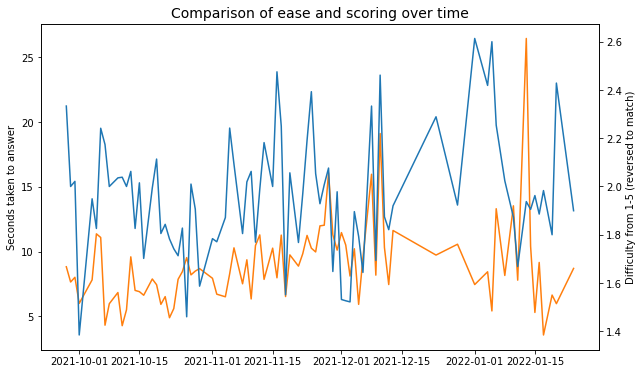

In [258]:
fig, ax = plt.subplots(figsize=(10,6))

color = 'tab:orange'
ax.plot(day_avgs.index, day_avgs['time']/1000, label='Time taken to answer card', color=color)
ax.set_ylabel('Seconds taken to answer')

color = 'tab:blue'
ax1 = ax.twinx()
ax1.plot(day_avgs.index, 5-day_avgs['ease'], label='Ease of recall from (inverse)', color=color)
ax1.set_title("Comparison of ease and scoring over time",size=14)
ax1.set_ylabel('Difficulty from 1-5 (reversed to match)')
;

In [ ]:
# An alternative way of getting timestamps, using the time module rather than pandas

# I used this at first but then found that it wasn't creating the times as timestamp objects, 
# so I used the pandas method instead. 

"""

# We need to divide by 1000 since Anki's timestamp is in milliseconds

for i in range(df.shape[0]):
    timestamp = time.gmtime(df.iloc[i,0]/1000) 
    df.iloc[i,9] = time.strftime("%H:%M:%S", timestamp)
    df.iloc[i,10] = time.strftime("%Y-%m-%d", timestamp)"""